In [1]:
import csv
import itertools
import os
import re
from collections import Counter
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
from string import punctuation

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tslib import Timestamp

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 100
matplotlib.rcParams['lines.linewidth'] = 1.0

# Grupos

## Socios activos 2016

In [3]:
# 1.       CTA: categoría para niños y jóvenes hasta bachillerato
# 2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
# 3.       CTB: público general (solo permite préstamo de libros)
# 4.       CTC: público en general (permite préstamo de libros y material audiovisual)
# 5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
# 6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
# 7.       CIS: categoría Inclusión Social
# 8.       CTU: categoría Universitaria
# 9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

#      Categoría de lector: CE1 Categoría empresarial                                   218
#      Categoría de lector: CE2 Categoría empresarial 2                                   5
#      Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
#      Categoría de lector: CIN Categoría Interbibliotecario                            128
#      Categoría de lector: CIP Categoría Investigador                                  351
#      Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
#      Categoría de lector: CIV Categoría Investigadores                                 72
#      Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
#      Categoría de lector: CSU Categoría Sucursal                                       91
#      Categoría de lector: CTA Categoría Básica A                                    10610
#      Categoría de lector: CTB Categoría B                                            1359
#      Categoría de lector: CTC Categoría C                                             224
#      Categoría de lector: CTF Categoría familiar                                     1105
#      Categoría de lector: CTI Categoría Infantil                                     1004
#      Categoría de lector: CTU Categoría General                                     17402
#      Categoría de lector: PTE PROCESOS TÉCNICOS                                        95

In [4]:
%%time

dtypes = {
    'Sucursal': str,
    'Tratamiento': str,
    'Barrio': str,
    'Ciudad': str,
    'CATEG': str,
    'Ocupación1': str,
    'Nivel Estudio1': str,
    'Área de Estudio1': str,
    'Edad': 'category',
}

perfiles_df = pd.read_csv(
    'valores_grupos_2016.csv', header=0, dtype=dtypes)
# perfiles_df = perfiles_df.fillna('')

CPU times: user 67.2 ms, sys: 3.85 ms, total: 71.1 ms
Wall time: 71.6 ms


In [5]:
perfiles_df.shape

(50272, 9)

In [6]:
perfiles_df.head()

,Sucursal,Tratamiento,Barrio,Ciudad,CATEG,Ocupación1,Nivel Estudio1,Área de Estudio1,Edad
0,BLAA,OTRO,chapinero,bogota,CIN,universidad,OTRO,OTRO,OTRO
1,BLAA,sra.,OTRO,bogota,CEM,pensionado,OTRO,OTRO,50-64
2,BLAA,sra.,icata,bogota,CEM,empleado,profesional,filosofía y letras,OTRO
3,ARM,sr.,OTRO,OTRO,CEM,empleado,profesional,economía,50-64
4,BLAA,sr.,soledad,bogota,CEM,OTRO,OTRO,OTRO,OTRO


# Agrupando valores frecuentes

### Grupos (I)

In [7]:
groups = [tuple(x) for i, x in perfiles_df.iterrows()]
counter = Counter(groups)

In [8]:
len(counter)

42360

In [9]:
counter.most_common(1)

[(('BUE',
   'sr.',
   'olimpico',
   'buenaventura',
   'CTA',
   'estudiante',
   'básica primaria',
   'OTRO',
   '17-'),
  75)]

##### => 50272 usuarios repartidos en 42575 grupos muy poco numerosos (sólo 75 usuarios el de mayor tamaño)

### Porcentajes sin valores

In [10]:
columns = sorted(dtypes)

In [11]:
for c in columns:
    cns = perfiles_df[c].value_counts()
    total = cns.sum()
    otros = 0
    if 'OTRO' in cns:
        otros = cns.ix['OTRO']
    perc = '{:.2%}'.format(otros/total)
    unique = perfiles_df[c].nunique()
    print(c, perc, unique)

Barrio 12.10% 3420
CATEG 0.00% 15
Ciudad 5.60% 83
Edad 13.18% 7
Nivel Estudio1 12.68% 13
Ocupación1 3.64% 17
Sucursal 0.02% 31
Tratamiento 10.79% 3
Área de Estudio1 46.69% 113


##### => Eliminar columna Área de Estudio1 (46.69% sin valor)

### Sucursales y ciudades

In [12]:
sucursales_ciudades = {
    'ARM': 'armenia',
    'BAR': 'barranquilla',
    'BLAA': 'bogota',
    'BUE': 'buenaventura',
    'BUC': 'bucaramanga',
    'CAL': 'cali',
    'CAR': 'cartagena',
    'CASAGO': 'bogota',
    'CATMAN': 'bogota',
    'CUC': 'cucuta',
    'FLO': 'florencia',
    'GIR': 'girardot',
    'HON': 'honda',
    'IBA': 'ibague',
    'IEC': 'bogota',
    'IPI': 'ipiales',
    'LET': 'leticia',
    'MAN': 'manizales',
    'MED': 'medellin',
    'MON': 'monteria',
    'NEI': 'neiva',
    'PAS': 'pasto',
    'PER': 'pereira',
    'POP': 'popayan',
    'QUI': 'quibdo',
    'RIO': 'riohacha',
    'SAN': 'san andres',
    'SIN': 'sincelejo',
    'STM': 'santa marta',
    'TUN': 'tunja',
    'VAL': 'valledupar',
    'VIL': 'villavicencio',
}


In [13]:
p = q = r = 0

for i, x in perfiles_df.iterrows():
    s = x['Sucursal']
    cs = sucursales_ciudades.get(s, 'OTRO')
    c = x['Ciudad']
    if cs == c =='OTRO':
        p += 1
    elif cs == c:
        q += 1
    else:
        r += 1

print(p, q, r)
print('{:.2%}'.format((p + q) / (p + q + r)))

8 44290 5974
88.12%


##### => Eliminar columna Ciudad (88.12% duplicados)

### Grupos (II)

In [14]:
provisional_columns = ['Sucursal', 'Tratamiento', 'Barrio', 'CATEG', 'Ocupación1', 'Nivel Estudio1', 'Edad',]

In [15]:
groups = [tuple(x) for i, x in perfiles_df[provisional_columns].iterrows()]
counter = Counter(groups)

In [16]:
len(counter)

36231

In [17]:
counter.most_common(1)

[(('BLAA',
   'sr.',
   'OTRO',
   'CIS',
   'estudiante',
   'universitario 1 nivel',
   '18-29'),
  116)]

##### => 50272 usuarios repartidos en 36161 grupos muy poco numerosos (sólo 120 usuarios el de mayor tamaño)

### Combinaciones

In [18]:
def combinations(ls, yes=[], no=[]):
    def basic_combinations(ls):
        combs = []
        for i in range(1, len(ls) + 1):
            combs.append(itertools.combinations(ls, i))
        combs = [c for comb in combs for c in comb]
        return combs
    
    combs = basic_combinations(ls)
    
    aux = list(combs)
    for e in yes:
        for c in combs:
            if e not in c:
                if c in aux:
                    aux.remove(c)
    
    result = list(aux)
    for e in no:
        for c in aux:
            if e in c:
                if c in result:
                    result.remove(c)
    
    return result

In [19]:
sorted(provisional_columns)

['Barrio',
 'CATEG',
 'Edad',
 'Nivel Estudio1',
 'Ocupación1',
 'Sucursal',
 'Tratamiento']

In [20]:
columns

['Barrio',
 'CATEG',
 'Ciudad',
 'Edad',
 'Nivel Estudio1',
 'Ocupación1',
 'Sucursal',
 'Tratamiento',
 'Área de Estudio1']

In [21]:
combs = combinations(columns, yes=['Edad', 'Tratamiento'], no=['Barrio', 'Ciudad', 'Área de Estudio1'])

In [22]:
len(combs)

16

In [23]:
%%time

combinations_counter_dict = {}

for comb in combs:
    df = perfiles_df[list(comb)]
    groups = [tuple(x) for i, x in df.iterrows() if 'OTRO' not in tuple(x)]
    counter = Counter(groups)
    combinations_counter_dict[comb] = counter
    print(comb, len(counter))

('Edad', 'Tratamiento') 12
('CATEG', 'Edad', 'Tratamiento') 113
('Edad', 'Nivel Estudio1', 'Tratamiento') 138
('Edad', 'Ocupación1', 'Tratamiento') 142
('Edad', 'Sucursal', 'Tratamiento') 348
('CATEG', 'Edad', 'Nivel Estudio1', 'Tratamiento') 677
('CATEG', 'Edad', 'Ocupación1', 'Tratamiento') 558
('CATEG', 'Edad', 'Sucursal', 'Tratamiento') 1318
('Edad', 'Nivel Estudio1', 'Ocupación1', 'Tratamiento') 734
('Edad', 'Nivel Estudio1', 'Sucursal', 'Tratamiento') 1763
('Edad', 'Ocupación1', 'Sucursal', 'Tratamiento') 1404
('CATEG', 'Edad', 'Nivel Estudio1', 'Ocupación1', 'Tratamiento') 1916
('CATEG', 'Edad', 'Nivel Estudio1', 'Sucursal', 'Tratamiento') 3366
('CATEG', 'Edad', 'Ocupación1', 'Sucursal', 'Tratamiento') 2824
('Edad', 'Nivel Estudio1', 'Ocupación1', 'Sucursal', 'Tratamiento') 3394
('CATEG', 'Edad', 'Nivel Estudio1', 'Ocupación1', 'Sucursal', 'Tratamiento') 5292
CPU times: user 1min 17s, sys: 43.2 ms, total: 1min 17s
Wall time: 1min 17s


COMBINATION # 1
GROUP BY: ('Edad', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 348
TOP 12 LARGEST GROUPS:


,"(Edad, Sucursal, Tratamiento)",size,total,percentage
0,"(18-29, BLAA, sra.)",5276,39173,13.47%
1,"(18-29, BLAA, sr.)",4940,39173,12.61%
2,"(30-39, BLAA, sr.)",2243,39173,5.73%
3,"(30-39, BLAA, sra.)",1845,39173,4.71%
4,"(17-, TUN, sra.)",1092,39173,2.79%
5,"(40-49, BLAA, sr.)",929,39173,2.37%
6,"(50-64, BLAA, sr.)",892,39173,2.28%
7,"(17-, TUN, sr.)",714,39173,1.82%
8,"(40-49, BLAA, sra.)",641,39173,1.64%
9,"(17-, BLAA, sra.)",605,39173,1.54%


COMBINATION # 2
GROUP BY: ('CATEG', 'Edad', 'Ocupación1', 'Tratamiento')
NUMBER OF GROUPS: 558
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Ocupación1, Tratamiento)",size,total,percentage
0,"(CTA, 17-, estudiante, sra.)",4617,38283,12.06%
1,"(CTU, 18-29, estudiante, sra.)",3306,38283,8.64%
2,"(CTA, 17-, estudiante, sr.)",3305,38283,8.63%
3,"(CIS, 18-29, estudiante, sra.)",3267,38283,8.53%
4,"(CIS, 18-29, estudiante, sr.)",3220,38283,8.41%
5,"(CTU, 18-29, estudiante, sr.)",2908,38283,7.60%
6,"(CTU, 30-39, estudiante, sr.)",930,38283,2.43%
7,"(CTU, 30-39, estudiante, sra.)",729,38283,1.90%
8,"(CIS, 17-, estudiante, sra.)",514,38283,1.34%
9,"(CTU, 17-, estudiante, sra.)",491,38283,1.28%


COMBINATION # 3
GROUP BY: ('Edad', 'Nivel Estudio1', 'Ocupación1', 'Tratamiento')
NUMBER OF GROUPS: 734
TOP 12 LARGEST GROUPS:


,"(Edad, Nivel Estudio1, Ocupación1, Tratamiento)",size,total,percentage
0,"(18-29, universitario 1 nivel, estudiante, sra.)",3161,36104,8.76%
1,"(18-29, universitario 1 nivel, estudiante, sr.)",3033,36104,8.40%
2,"(17-, básica primaria, estudiante, sra.)",2876,36104,7.97%
3,"(18-29, universitario 2 nivel, estudiante, sra.)",2675,36104,7.41%
4,"(17-, secundaria, estudiante, sra.)",2604,36104,7.21%
5,"(18-29, universitario 2 nivel, estudiante, sr.)",2408,36104,6.67%
6,"(17-, básica primaria, estudiante, sr.)",2180,36104,6.04%
7,"(17-, secundaria, estudiante, sr.)",1724,36104,4.78%
8,"(30-39, universitario 2 nivel, estudiante, sr.)",622,36104,1.72%
9,"(30-39, universitario 2 nivel, estudiante, sra.)",419,36104,1.16%


COMBINATION # 4
GROUP BY: ('CATEG', 'Edad', 'Nivel Estudio1', 'Ocupación1', 'Tratamiento')
NUMBER OF GROUPS: 1916
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Nivel Estudio1, Ocupación1, Tratamiento)",size,total,percentage
0,"(CTA, 17-, básica primaria, estudiante, sra.)",2703,36104,7.49%
1,"(CTA, 17-, básica primaria, estudiante, sr.)",2071,36104,5.74%
2,"(CTA, 17-, secundaria, estudiante, sra.)",1746,36104,4.84%
3,"(CIS, 18-29, universitario 1 nivel, estudiante...",1734,36104,4.80%
4,"(CIS, 18-29, universitario 1 nivel, estudiante...",1703,36104,4.72%
5,"(CTU, 18-29, universitario 2 nivel, estudiante...",1535,36104,4.25%
6,"(CTU, 18-29, universitario 2 nivel, estudiante...",1316,36104,3.65%
7,"(CTU, 18-29, universitario 1 nivel, estudiante...",1312,36104,3.63%
8,"(CTU, 18-29, universitario 1 nivel, estudiante...",1160,36104,3.21%
9,"(CTA, 17-, secundaria, estudiante, sr.)",1104,36104,3.06%


COMBINATION # 5
GROUP BY: ('Edad', 'Nivel Estudio1', 'Ocupación1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 3394
TOP 12 LARGEST GROUPS:


,"(Edad, Nivel Estudio1, Ocupación1, Sucursal, Tratamiento)",size,total,percentage
0,"(18-29, universitario 1 nivel, estudiante, BLA...",2031,36102,5.63%
1,"(18-29, universitario 1 nivel, estudiante, BLA...",2015,36102,5.58%
2,"(18-29, universitario 2 nivel, estudiante, BLA...",1867,36102,5.17%
3,"(18-29, universitario 2 nivel, estudiante, BLA...",1589,36102,4.40%
4,"(17-, básica primaria, estudiante, TUN, sra.)",849,36102,2.35%
5,"(17-, básica primaria, estudiante, TUN, sr.)",515,36102,1.43%
6,"(30-39, universitario 2 nivel, estudiante, BLA...",445,36102,1.23%
7,"(17-, secundaria, estudiante, NEI, sra.)",381,36102,1.06%
8,"(17-, básica primaria, estudiante, POP, sra.)",374,36102,1.04%
9,"(17-, secundaria, estudiante, IPI, sra.)",315,36102,0.87%


COMBINATION # 6
GROUP BY: ('CATEG', 'Edad', 'Ocupación1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 2824
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Ocupación1, Sucursal, Tratamiento)",size,total,percentage
0,"(CTU, 18-29, estudiante, BLAA, sra.)",2394,38281,6.25%
1,"(CTU, 18-29, estudiante, BLAA, sr.)",1993,38281,5.21%
2,"(CIS, 18-29, estudiante, BLAA, sr.)",1982,38281,5.18%
3,"(CIS, 18-29, estudiante, BLAA, sra.)",1828,38281,4.78%
4,"(CTA, 17-, estudiante, TUN, sra.)",933,38281,2.44%
5,"(CTU, 30-39, estudiante, BLAA, sr.)",641,38281,1.67%
6,"(CTA, 17-, estudiante, TUN, sr.)",609,38281,1.59%
7,"(CTU, 30-39, estudiante, BLAA, sra.)",555,38281,1.45%
8,"(CTA, 17-, estudiante, POP, sra.)",539,38281,1.41%
9,"(CTA, 17-, estudiante, IPI, sra.)",426,38281,1.11%


COMBINATION # 7
GROUP BY: ('Edad', 'Ocupación1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 1404
TOP 12 LARGEST GROUPS:


,"(Edad, Ocupación1, Sucursal, Tratamiento)",size,total,percentage
0,"(18-29, estudiante, BLAA, sra.)",4527,38281,11.83%
1,"(18-29, estudiante, BLAA, sr.)",4254,38281,11.11%
2,"(17-, estudiante, TUN, sra.)",1062,38281,2.77%
3,"(30-39, estudiante, BLAA, sr.)",980,38281,2.56%
4,"(30-39, estudiante, BLAA, sra.)",791,38281,2.07%
5,"(17-, estudiante, TUN, sr.)",689,38281,1.80%
6,"(17-, estudiante, BLAA, sra.)",574,38281,1.50%
7,"(17-, estudiante, POP, sra.)",572,38281,1.49%
8,"(17-, estudiante, NEI, sra.)",527,38281,1.38%
9,"(30-39, empleado, BLAA, sr.)",471,38281,1.23%


COMBINATION # 8
GROUP BY: ('Edad', 'Nivel Estudio1', 'Tratamiento')
NUMBER OF GROUPS: 138
TOP 12 LARGEST GROUPS:


,"(Edad, Nivel Estudio1, Tratamiento)",size,total,percentage
0,"(18-29, universitario 1 nivel, sra.)",3272,36149,9.05%
1,"(18-29, universitario 1 nivel, sr.)",3152,36149,8.72%
2,"(17-, básica primaria, sra.)",2883,36149,7.98%
3,"(18-29, universitario 2 nivel, sra.)",2762,36149,7.64%
4,"(17-, secundaria, sra.)",2614,36149,7.23%
5,"(18-29, universitario 2 nivel, sr.)",2509,36149,6.94%
6,"(17-, básica primaria, sr.)",2187,36149,6.05%
7,"(17-, secundaria, sr.)",1731,36149,4.79%
8,"(30-39, profesional, sr.)",1110,36149,3.07%
9,"(30-39, profesional, sra.)",915,36149,2.53%


COMBINATION # 9
GROUP BY: ('CATEG', 'Edad', 'Nivel Estudio1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 3366
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Nivel Estudio1, Sucursal, Tratamiento)",size,total,percentage
0,"(CTU, 18-29, universitario 2 nivel, BLAA, sra.)",1264,36147,3.50%
1,"(CIS, 18-29, universitario 1 nivel, BLAA, sr.)",1187,36147,3.28%
2,"(CIS, 18-29, universitario 1 nivel, BLAA, sra.)",1049,36147,2.90%
3,"(CTU, 18-29, universitario 2 nivel, BLAA, sr.)",1046,36147,2.89%
4,"(CTU, 18-29, universitario 1 nivel, BLAA, sra.)",962,36147,2.66%
5,"(CTU, 18-29, universitario 1 nivel, BLAA, sr.)",851,36147,2.35%
6,"(CTA, 17-, básica primaria, TUN, sra.)",845,36147,2.34%
7,"(CTU, 30-39, profesional, BLAA, sr.)",577,36147,1.60%
8,"(CTA, 17-, básica primaria, TUN, sr.)",514,36147,1.42%
9,"(CIS, 18-29, universitario 2 nivel, BLAA, sra.)",498,36147,1.38%


COMBINATION # 10
GROUP BY: ('CATEG', 'Edad', 'Tratamiento')
NUMBER OF GROUPS: 113
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Tratamiento)",size,total,percentage
0,"(CTA, 17-, sra.)",4805,39175,12.27%
1,"(CTU, 18-29, sra.)",3972,39175,10.14%
2,"(CIS, 18-29, sra.)",3622,39175,9.25%
3,"(CTU, 18-29, sr.)",3545,39175,9.05%
4,"(CIS, 18-29, sr.)",3534,39175,9.02%
5,"(CTA, 17-, sr.)",3503,39175,8.94%
6,"(CTU, 30-39, sr.)",2265,39175,5.78%
7,"(CTU, 30-39, sra.)",1813,39175,4.63%
8,"(CTU, 40-49, sr.)",955,39175,2.44%
9,"(CTU, 50-64, sr.)",717,39175,1.83%


COMBINATION # 11
GROUP BY: ('Edad', 'Tratamiento')
NUMBER OF GROUPS: 12
TOP 12 LARGEST GROUPS:


,"(Edad, Tratamiento)",size,total,percentage
0,"(18-29, sra.)",8343,39175,21.30%
1,"(18-29, sr.)",7816,39175,19.95%
2,"(17-, sra.)",6253,39175,15.96%
3,"(17-, sr.)",4527,39175,11.56%
4,"(30-39, sr.)",3391,39175,8.66%
5,"(30-39, sra.)",2850,39175,7.28%
6,"(50-64, sr.)",1566,39175,4.00%
7,"(40-49, sr.)",1445,39175,3.69%
8,"(40-49, sra.)",1028,39175,2.62%
9,"(50-64, sra.)",832,39175,2.12%


COMBINATION # 12
GROUP BY: ('CATEG', 'Edad', 'Nivel Estudio1', 'Tratamiento')
NUMBER OF GROUPS: 677
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Nivel Estudio1, Tratamiento)",size,total,percentage
0,"(CTA, 17-, básica primaria, sra.)",2709,36149,7.49%
1,"(CTA, 17-, básica primaria, sr.)",2076,36149,5.74%
2,"(CIS, 18-29, universitario 1 nivel, sr.)",1774,36149,4.91%
3,"(CTA, 17-, secundaria, sra.)",1750,36149,4.84%
4,"(CIS, 18-29, universitario 1 nivel, sra.)",1748,36149,4.84%
5,"(CTU, 18-29, universitario 2 nivel, sra.)",1598,36149,4.42%
6,"(CTU, 18-29, universitario 2 nivel, sr.)",1389,36149,3.84%
7,"(CTU, 18-29, universitario 1 nivel, sra.)",1366,36149,3.78%
8,"(CTU, 18-29, universitario 1 nivel, sr.)",1227,36149,3.39%
9,"(CTA, 17-, secundaria, sr.)",1107,36149,3.06%


COMBINATION # 13
GROUP BY: ('Edad', 'Ocupación1', 'Tratamiento')
NUMBER OF GROUPS: 142
TOP 12 LARGEST GROUPS:


,"(Edad, Ocupación1, Tratamiento)",size,total,percentage
0,"(18-29, estudiante, sra.)",7164,38283,18.71%
1,"(18-29, estudiante, sr.)",6718,38283,17.55%
2,"(17-, estudiante, sra.)",6006,38283,15.69%
3,"(17-, estudiante, sr.)",4272,38283,11.16%
4,"(30-39, estudiante, sr.)",1530,38283,4.00%
5,"(30-39, estudiante, sra.)",1191,38283,3.11%
6,"(30-39, empleado, sr.)",648,38283,1.69%
7,"(30-39, empleado, sra.)",588,38283,1.54%
8,"(30-39, docente, sr.)",498,38283,1.30%
9,"(30-39, docente, sra.)",430,38283,1.12%


COMBINATION # 14
GROUP BY: ('CATEG', 'Edad', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 1318
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Sucursal, Tratamiento)",size,total,percentage
0,"(CTU, 18-29, BLAA, sra.)",2868,39173,7.32%
1,"(CTU, 18-29, BLAA, sr.)",2423,39173,6.19%
2,"(CIS, 18-29, BLAA, sr.)",2151,39173,5.49%
3,"(CIS, 18-29, BLAA, sra.)",1993,39173,5.09%
4,"(CTU, 30-39, BLAA, sr.)",1581,39173,4.04%
5,"(CTU, 30-39, BLAA, sra.)",1331,39173,3.40%
6,"(CTA, 17-, TUN, sra.)",963,39173,2.46%
7,"(CTU, 40-49, BLAA, sr.)",644,39173,1.64%
8,"(CTA, 17-, TUN, sr.)",632,39173,1.61%
9,"(CTA, 17-, POP, sra.)",541,39173,1.38%


COMBINATION # 15
GROUP BY: ('CATEG', 'Edad', 'Nivel Estudio1', 'Ocupación1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 5292
TOP 12 LARGEST GROUPS:


,"(CATEG, Edad, Nivel Estudio1, Ocupación1, Sucursal, Tratamiento)",size,total,percentage
0,"(CTU, 18-29, universitario 2 nivel, estudiante...",1209,36102,3.35%
1,"(CIS, 18-29, universitario 1 nivel, estudiante...",1151,36102,3.19%
2,"(CIS, 18-29, universitario 1 nivel, estudiante...",1011,36102,2.80%
3,"(CTU, 18-29, universitario 2 nivel, estudiante...",982,36102,2.72%
4,"(CTU, 18-29, universitario 1 nivel, estudiante...",915,36102,2.53%
5,"(CTA, 17-, básica primaria, estudiante, TUN, s...",845,36102,2.34%
6,"(CTU, 18-29, universitario 1 nivel, estudiante...",795,36102,2.20%
7,"(CTA, 17-, básica primaria, estudiante, TUN, sr.)",514,36102,1.42%
8,"(CIS, 18-29, universitario 2 nivel, estudiante...",490,36102,1.36%
9,"(CIS, 18-29, universitario 2 nivel, estudiante...",452,36102,1.25%


COMBINATION # 16
GROUP BY: ('Edad', 'Nivel Estudio1', 'Sucursal', 'Tratamiento')
NUMBER OF GROUPS: 1763
TOP 12 LARGEST GROUPS:


,"(Edad, Nivel Estudio1, Sucursal, Tratamiento)",size,total,percentage
0,"(18-29, universitario 1 nivel, BLAA, sr.)",2129,36147,5.89%
1,"(18-29, universitario 1 nivel, BLAA, sra.)",2109,36147,5.83%
2,"(18-29, universitario 2 nivel, BLAA, sra.)",1940,36147,5.37%
3,"(18-29, universitario 2 nivel, BLAA, sr.)",1670,36147,4.62%
4,"(17-, básica primaria, TUN, sra.)",849,36147,2.35%
5,"(30-39, profesional, BLAA, sr.)",746,36147,2.06%
6,"(30-39, profesional, BLAA, sra.)",627,36147,1.73%
7,"(30-39, universitario 2 nivel, BLAA, sr.)",533,36147,1.47%
8,"(17-, básica primaria, TUN, sr.)",515,36147,1.42%
9,"(50-64, profesional, BLAA, sr.)",477,36147,1.32%


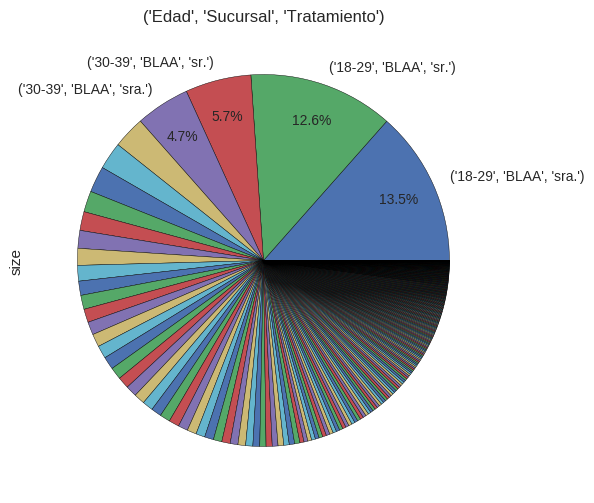

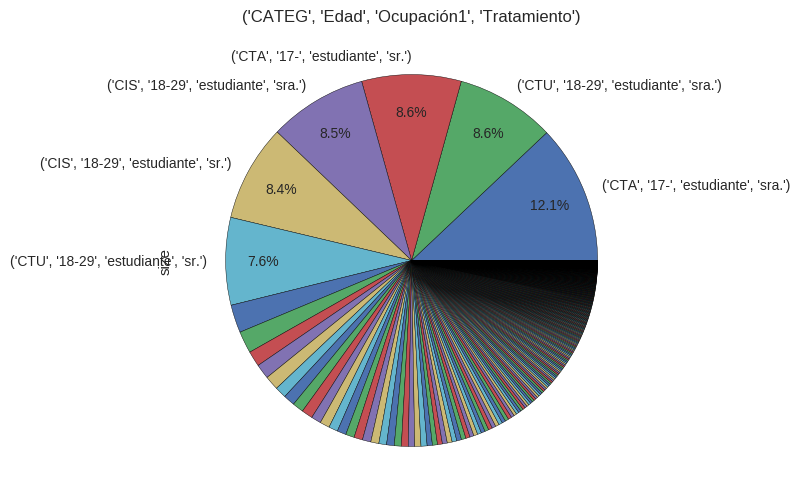

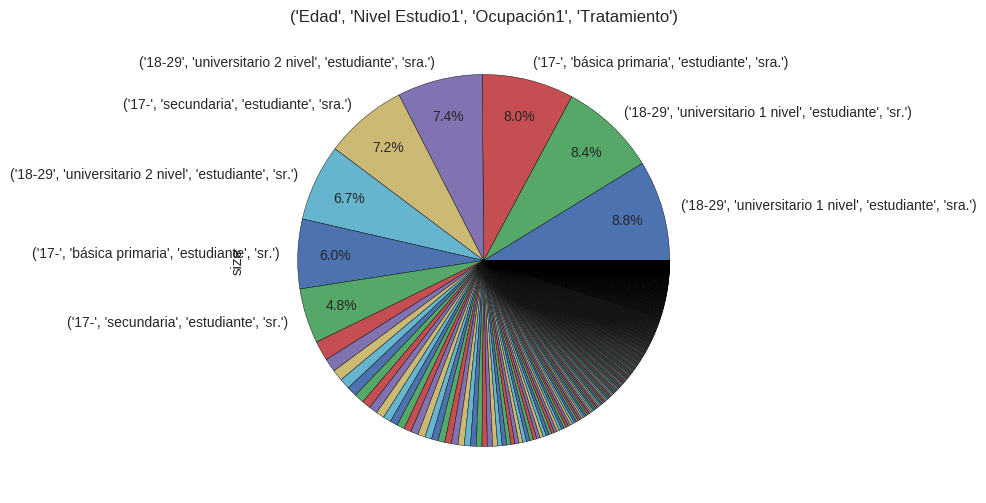

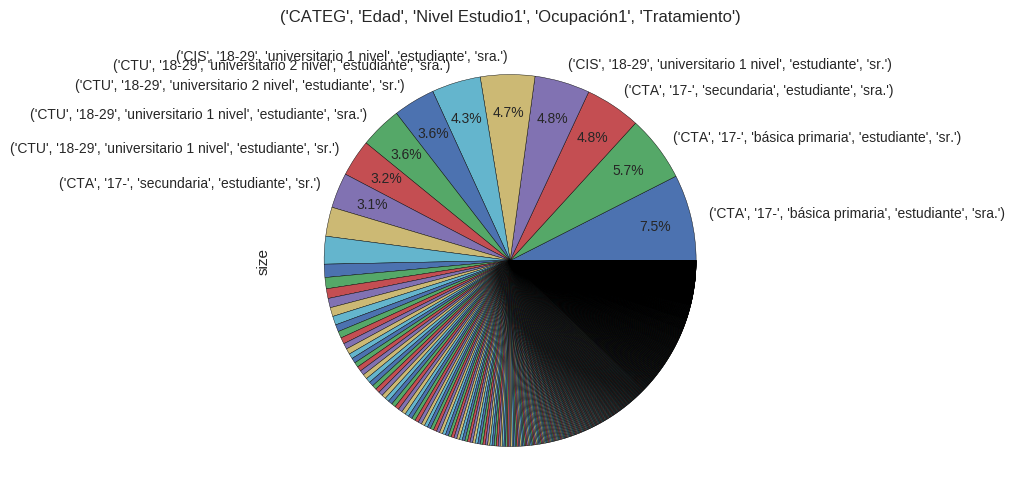

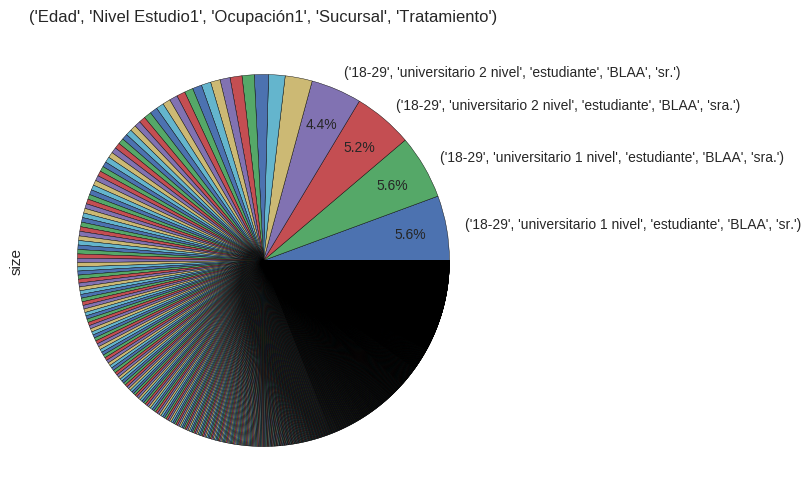

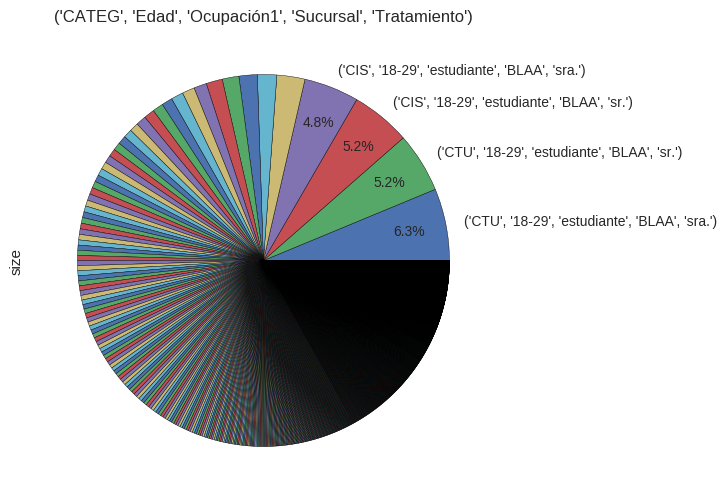

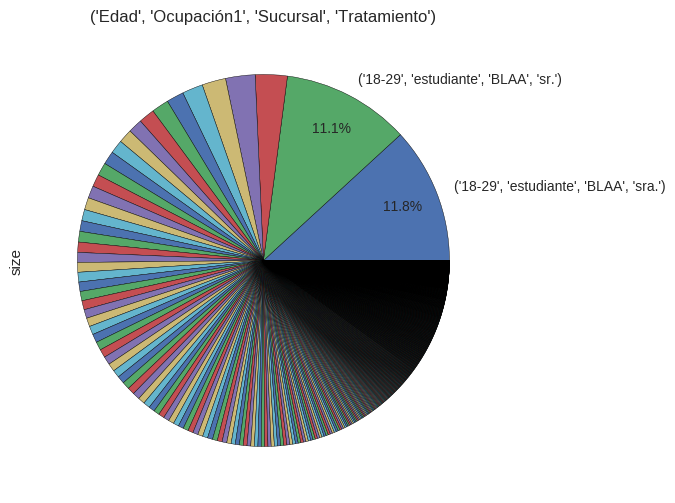

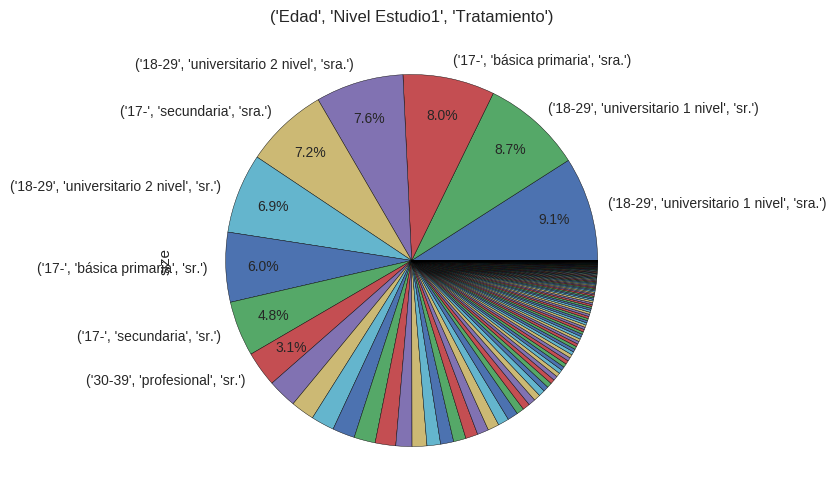

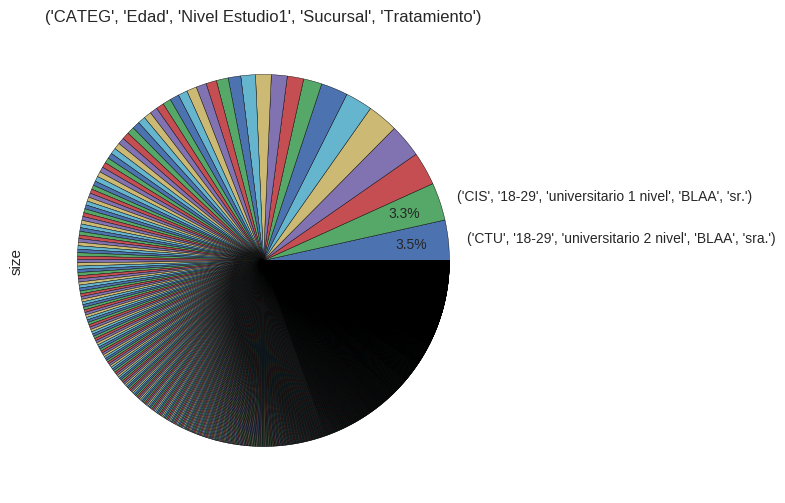

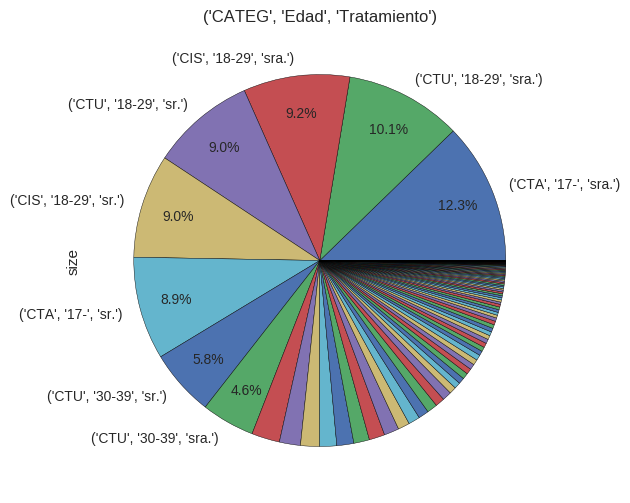

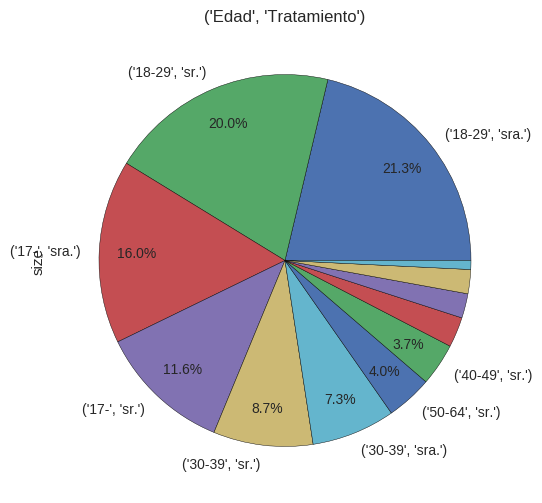

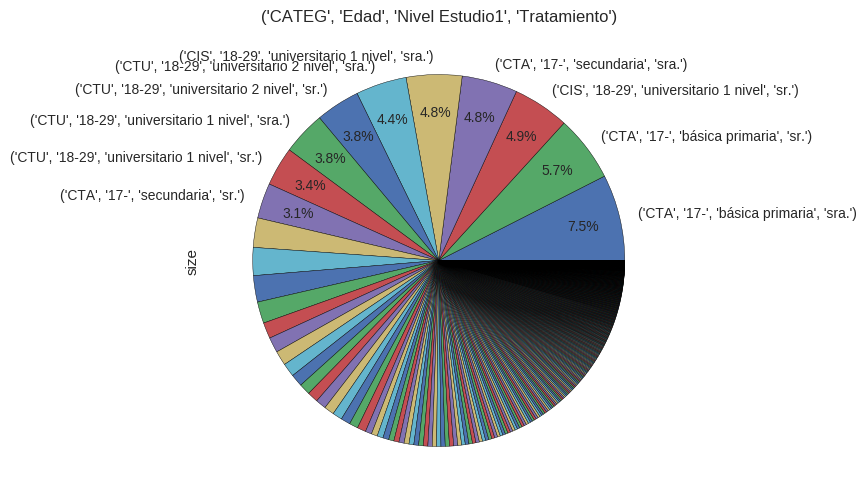

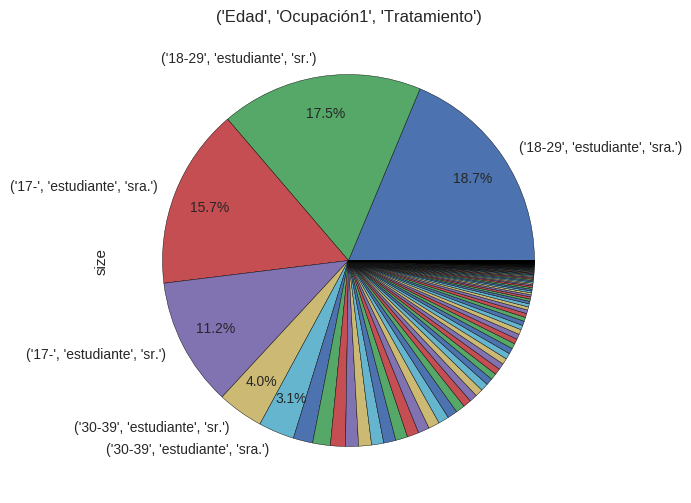

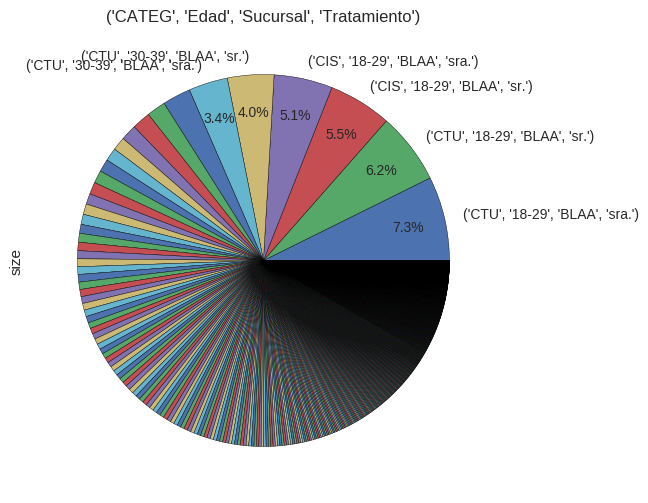

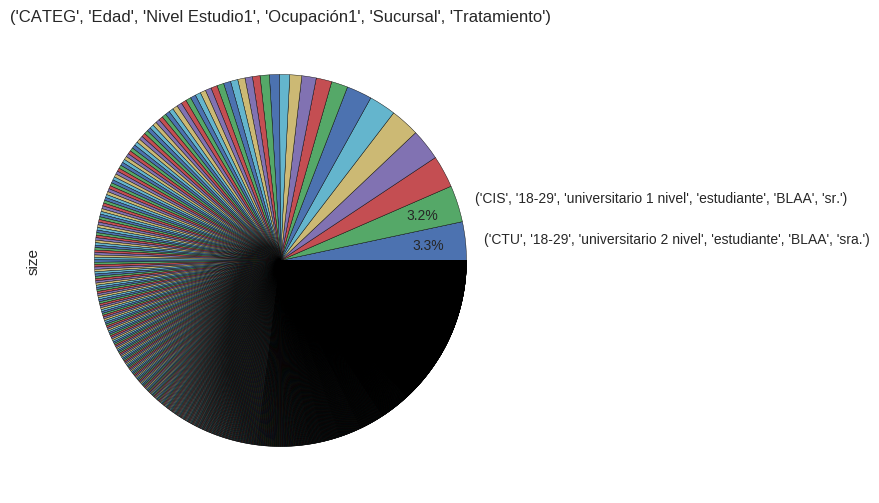

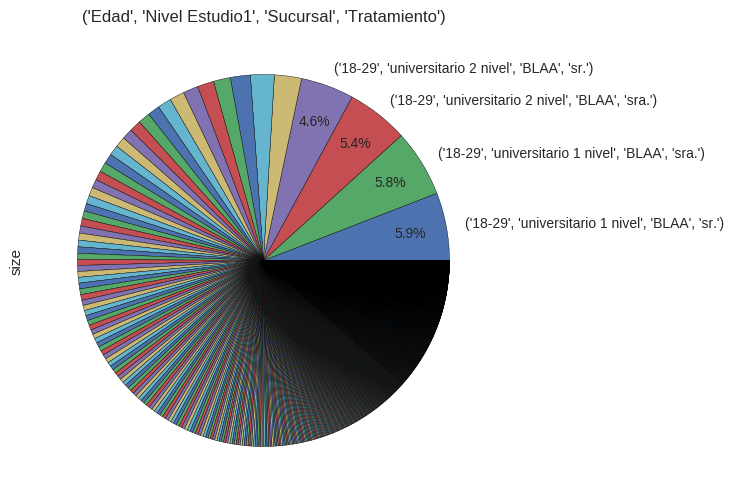

In [24]:
from IPython.display import display


def mypct(pct):
    return '%.1f%%' % pct if pct >= THRESHOLD else ''

def mylabels(count_df):
    return [(x if float(count_df.ix[[x]]['percentage'][0][:-1]) >= THRESHOLD else '') for x in count_df.index]

THRESHOLD = 3
N = 12
c = 1
for k in combinations_counter_dict:
    cn = combinations_counter_dict[k]
    print('COMBINATION #', c)
    print('GROUP BY:', k)
    print('NUMBER OF GROUPS:', len(cn))
    print('TOP', N, 'LARGEST GROUPS:')
    total = sum(cn.values())
    df = pd.DataFrame(
        [(a, b, total, '{:.2%}'.format(b / total)) for a, b in cn.most_common()],
        columns=(k, 'size', 'total', 'percentage'),
    )
    display(df.head(N))
    c += 1
    
    plt.figure()
    count_df = df.set_index(k)
    count_df['size'].plot(kind='pie', autopct=mypct, pctdistance=0.8, labels=mylabels(count_df), figsize=(6,6), title=k)